In [73]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

In [74]:
tracks = pd.read_csv("fma-rock-vs-hiphop.csv")
print(tracks.columns, end = '\n\n')
print(tracks.shape, end = '\n\n')

echonest_metrics = pd.read_json("echonest-metrics.json", precise_float = True)
print(echonest_metrics.columns, end = '\n\n')
print(echonest_metrics.shape, end = '\n\n')

echo_tracks = echonest_metrics.merge(tracks[['track_id','genre_top']], on = 'track_id')
print(echo_tracks.columns, end = '\n\n')
print(echo_tracks.shape, end = '\n\n')

echo_tracks.info()

Index(['track_id', 'bit_rate', 'comments', 'composer', 'date_created',
       'date_recorded', 'duration', 'favorites', 'genre_top', 'genres',
       'genres_all', 'information', 'interest', 'language_code', 'license',
       'listens', 'lyricist', 'number', 'publisher', 'tags', 'title'],
      dtype='object')

(17734, 21)

Index(['track_id', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence'],
      dtype='object')

(13129, 9)

Index(['track_id', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence',
       'genre_top'],
      dtype='object')

(4802, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability

In [75]:
numeric_columns = echo_tracks.select_dtypes(include = ['number'])

corr_metrics = numeric_columns.corr()
corr_metrics.style.background_gradient(cmap = "BrBG")

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


In [76]:
features = echo_tracks.drop(['genre_top','track_id'], axis = 1).values
print(features.shape)

labels = echo_tracks['genre_top'].values
print(labels.shape)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state = 10)

scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

(4802, 8)
(4802,)


Text(0.5, 0, 'Principal Component #')

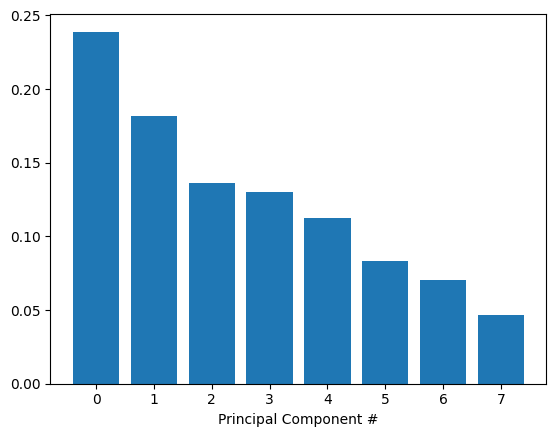

In [77]:
%matplotlib inline

pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

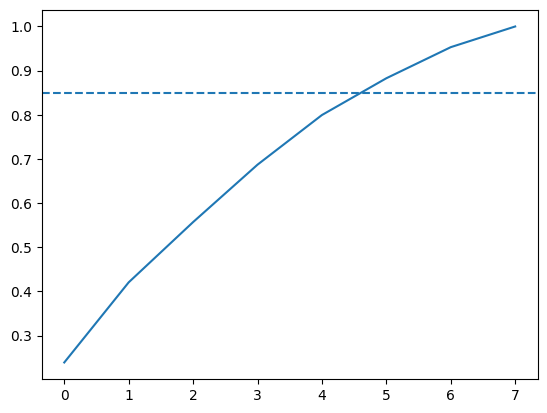

In [78]:
cum_exp_variance = np.cumsum(exp_variance)

fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y = 0.85, linestyle='--')

In [79]:
pca = PCA(n_components = 6)
train_pca = pca.fit_transform(scaled_train_features)
print(train_pca.shape)
test_pca = pca.transform(scaled_test_features)
print(test_pca.shape)

(3601, 6)
(1201, 6)


In [80]:
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)

pred_labels_tree = tree.predict(test_pca)

In [81]:
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca, train_labels)

pred_labels_logit = logreg.predict(test_pca)

In [82]:
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.62      0.60      0.61       235
        Rock       0.90      0.91      0.91       966

    accuracy                           0.85      1201
   macro avg       0.76      0.76      0.76      1201
weighted avg       0.85      0.85      0.85      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



In [83]:
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']
print(hop_only.shape)
print(rock_only.shape)

(910, 10)
(3892, 10)


In [84]:
rock_only = rock_only.sample(hop_only.shape[0], random_state = 10)

rock_hop_bal = pd.concat([rock_only, hop_only])

features = rock_hop_bal.drop(['genre_top', 'track_id'], axis = 1)
labels = rock_hop_bal['genre_top']
train_features, test_features, train_labels, test_labels = train_test_split(features, 
        labels, random_state = 10)

train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

In [85]:
tree = DecisionTreeClassifier(random_state = 10)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

logreg = LogisticRegression()
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.77      0.79       230
        Rock       0.78      0.83      0.80       225

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.81      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.83      0.82      0.82       455



In [86]:

tree_pipe = Pipeline([("scaler", StandardScaler()),
                      ("pca", PCA(n_components = 6)),
                      ("tree", DecisionTreeClassifier(random_state = 10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()),
                        ("pca", PCA(n_components = 6)),
                        ("logreg", LogisticRegression(random_state = 10))])

kf = KFold(10)

tree_score = cross_val_score(tree_pipe, features, labels, cv = kf)
logit_score = cross_val_score(logreg_pipe, features, labels, cv=kf)

print("Decision Tree:", tree_score.mean(), "Logistic Regression:", logit_score.mean())

Decision Tree: 0.7598901098901099 Logistic Regression: 0.782967032967033
